## Import relevant packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4 # for DenseNet121
from torchvision import models
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd

## Get computational device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Read Xray Images from the directory and pre process them

In [3]:
import os
import cv2
import numpy as np
import random

def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def random_brightness_contrast(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    """
    Apply random brightness and contrast adjustments to the image.
    
    Args:
        image (np.array): The image to adjust
        alpha_range (tuple): The range for contrast (scaling factor)
        beta_range (tuple): The range for brightness (additive factor)
    
    Returns:
        np.array: The adjusted image
    """
    alpha = random.uniform(*alpha_range)  # Random contrast factor
    beta = random.randint(*beta_range)  # Random brightness factor
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def read_xray_images(directory_path, img_height, img_width, augmentation=False, normalize=True):
    """
    Reads X-ray image data from directories, resizes images to the same size & performs cautious augmentation.
    Optionally normalizes the image to the range [0, 1].

    Args:
      directory_path (str): Path to the main directory containing class subdirectories (e.g., Atelectasis, Pneumonia)
      img_height (int): Height of image to resize to
      img_width (int): Width of image to resize to
      augmentation (bool): Whether to perform data augmentation or not
      normalize (bool): Whether to normalize image pixel values

    Returns:
      datax (np.array): NumPy array of images
      datay (np.array): NumPy array of labels (class names)
    """

    datax = [] 
    datay = [] 

    sub_directories = os.listdir(directory_path)

    for sub_dir in sub_directories: 
        sub_dir_path = os.path.join(directory_path, sub_dir)

        correct_image_filepaths = check_image_path(sub_dir_path)

        for fpath in correct_image_filepaths:  # Loop through the image file paths

            image = cv2.imread(fpath)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (img_width, img_height)) 

            if augmentation:
                image = random_brightness_contrast(image)

                if random.random() < 0.5:  # 50% chance to rotate
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

                datax.append(image)
                datay.append(sub_dir + '_aug')

            else:  
                datax.append(image)
                datay.append(sub_dir)

    return np.array(datax), np.array(datay)

## Download pre-trained model

In [4]:
resnet50_model = models.resnet50(pretrained=True)
densenet121_model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

## Model architecture

In [5]:
resnet50_model = resnet50_model.to(device)
print(resnet50_model)

densenet121_model = densenet121_model.to(device)
print(densenet121_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Summarize Model

In [6]:
summary(resnet50_model, (3, 224, 224), device=device)

summary(densenet121_model, (3, 224, 244), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

summary(resnet50_model, (3, 224, 224), device=device)
summary(densenet121_model, (3, 224, 244), device=device)

## Explore model layers and their child modules

The following cell allows you to check out the names of the main modules that make up each model. Run one model at a time and comment out code for the other two.

In [7]:

for name, module in resnet50_model.named_modules():
    print(name)


for name, module in densenet121_model.named_modules():
    print(name)
     


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [8]:
print(f"---Main modules---")
for name, module in resnet50_model.named_children():
    print(name)
    
print(f"---Child Modules for the 'layer4' module")
for name, module in resnet50_model.named_children():
    if name == "layer4":
        for n, m in module.named_children():
            print(n)

---Main modules---
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
---Child Modules for the 'layer4' module
0
1
2


In [9]:
print(f"---Main modules---")
for name, module in resnet50_model.named_children():
    print(name)

# Lets say you are interested in layer4
print(f"---Child Modules for the 'layer4' module")
for name, module in resnet50_model.named_children():
    if name == "layer4":
        for n, m in module.named_children():
            print(n)

---Main modules---
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
---Child Modules for the 'layer4' module
0
1
2


## Freeze all the layers of the model

In [10]:
for param in resnet50_model.parameters():
    param.requires_grad = False

for param in densenet121_model.parameters():
    param.requires_grad = False

In [11]:
resnet50_model.fc = nn.Flatten()
summary(resnet50_model, (3, 224, 224), device=device)


densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

## Unfreeze the layers you want for fine-tuning

In [12]:
for param in resnet50_model.layer4[2:].parameters():
    param.requires_grad = True

In [13]:
for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x == "denselayer16":
                        for param in y.parameters():
                            param.requires_grad = True

# also unfreeze the 'features.norm5' layers
for name, module in densenet121_model.features.named_children():
    if name == "norm5":
        for param in module.parameters():
            param.requires_grad = True

In [14]:
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

##  Get training,Validation data and Test data

In [15]:
img_height, img_width = 224, 224 
train_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Training"
validation_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Validation"
test_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Testing"

In [16]:
%%time
train_data_dir = train_data_dir
x_train, y_train = read_xray_images(train_data_dir, img_height, img_width, augmentation=True)

CPU times: user 1.1 s, sys: 255 ms, total: 1.35 s
Wall time: 1.76 s


In [17]:
x_train.shape, y_train.shape

((60, 224, 224, 3), (60,))

In [18]:
validation_data_dir = validation_data_dir
x_val, y_val = read_xray_images(validation_data_dir, img_height, img_width, augmentation=True)

In [19]:
x_val.shape, y_val.shape

((60, 224, 224, 3), (60,))

## Display Example Images

Class labels sampled: ['Cardiomegaly_aug' 'Atelectasis_aug']


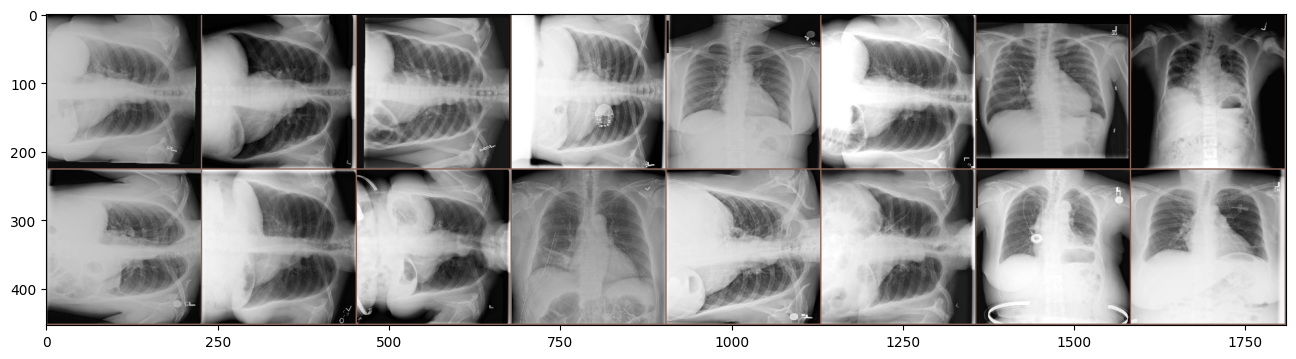

In [20]:
import sys

sys.path.append('/kaggle/input/scripts/other/default/1')

import prototypical_network
import train_and_evaluation

n_way = 2    
n_support = 5
n_query = 3   
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train) #  returns a dictionary
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

### Train a Prototypical Network using the model (2 way 3 shot DenseNet121)

In [21]:
model = prototypical_network.ProtoNet(densenet121_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 3   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

# name to save model as
filename = "DenseNet121-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 15.071 | Train Acc: 46.25%
	 Val. Loss: 11.877 | Val. Acc: 61.75%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 15.057 | Train Acc: 53.75%
	 Val. Loss: 12.587 | Val. Acc: 57.00%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 14.052 | Train Acc: 50.25%
	 Val. Loss: 10.878 | Val. Acc: 62.75%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 13.557 | Train Acc: 52.75%
	 Val. Loss: 11.559 | Val. Acc: 63.25%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 14.995 | Train Acc: 50.00%
	 Val. Loss: 13.461 | Val. Acc: 60.75%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 15.902 | Train Acc: 52.50%
	 Val. Loss: 14.329 | Val. Acc: 58.25%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 12.995 | Train Acc: 49.75%
	 Val. Loss: 11.863 | Val. Acc: 58.25%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 16.009 | Train Acc: 52.25%
	 Val. Loss: 11.446 | Val. Acc: 60.75%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 14.799 | Train Acc: 49.00%
	 Val. Loss: 11.042 | Val. Acc: 60.75%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 13.494 | Train Acc: 51.25%
	 Val. Loss: 12.428 | Val. Acc: 61.50%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 14.146 | Train Acc: 51.25%
	 Val. Loss: 9.448 | Val. Acc: 65.50%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 17.151 | Train Acc: 50.25%
	 Val. Loss: 11.788 | Val. Acc: 62.50%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 13.931 | Train Acc: 51.50%
	 Val. Loss: 11.141 | Val. Acc: 60.75%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 14.411 | Train Acc: 49.25%
	 Val. Loss: 11.073 | Val. Acc: 63.75%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 11.542 | Train Acc: 53.00%
	 Val. Loss: 11.579 | Val. Acc: 60.25%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 14.472 | Train Acc: 53.25%
	 Val. Loss: 13.825 | Val. Acc: 60.25%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 13.443 | Train Acc: 52.25%
	 Val. Loss: 10.678 | Val. Acc: 61.75%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 13.864 | Train Acc: 51.25%
	 Val. Loss: 16.756 | Val. Acc: 55.75%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 16.020 | Train Acc: 51.00%
	 Val. Loss: 12.953 | Val. Acc: 58.75%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 15.568 | Train Acc: 55.25%
	 Val. Loss: 13.134 | Val. Acc: 64.00%


In [22]:
# Calculate the average training and validation accuracies
average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)

# Print out the average accuracies and losses (as percentage)
print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

Average Training Accuracy: 0.51%
Average Validation Accuracy: 0.61%


## Train a Prototypical Network using the model (2 way 5 shot DenseNet121)

In [23]:
model = prototypical_network.ProtoNet(densenet121_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 5   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

filename = "DenseNet121-best-few-shot-model-10shot.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 9.029 | Train Acc: 54.00%
	 Val. Loss: 11.404 | Val. Acc: 59.75%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 8.991 | Train Acc: 58.00%
	 Val. Loss: 8.057 | Val. Acc: 62.75%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 6.705 | Train Acc: 61.00%
	 Val. Loss: 9.437 | Val. Acc: 60.25%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 9.181 | Train Acc: 60.00%
	 Val. Loss: 8.301 | Val. Acc: 59.50%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 8.174 | Train Acc: 60.25%
	 Val. Loss: 8.808 | Val. Acc: 64.50%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 8.566 | Train Acc: 58.75%
	 Val. Loss: 7.669 | Val. Acc: 64.25%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 6.162 | Train Acc: 59.25%
	 Val. Loss: 8.362 | Val. Acc: 59.50%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 9.216 | Train Acc: 57.50%
	 Val. Loss: 8.708 | Val. Acc: 58.75%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 6.958 | Train Acc: 63.00%
	 Val. Loss: 9.743 | Val. Acc: 62.75%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 7.559 | Train Acc: 61.00%
	 Val. Loss: 8.584 | Val. Acc: 64.00%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 6.432 | Train Acc: 61.75%
	 Val. Loss: 8.122 | Val. Acc: 59.75%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 7.873 | Train Acc: 61.75%
	 Val. Loss: 8.417 | Val. Acc: 62.25%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 7.176 | Train Acc: 66.00%
	 Val. Loss: 8.037 | Val. Acc: 63.25%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 6.753 | Train Acc: 62.75%
	 Val. Loss: 8.901 | Val. Acc: 60.50%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 7.183 | Train Acc: 63.50%
	 Val. Loss: 7.759 | Val. Acc: 63.25%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 9.689 | Train Acc: 58.50%
	 Val. Loss: 9.812 | Val. Acc: 62.25%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 8.025 | Train Acc: 58.50%
	 Val. Loss: 6.351 | Val. Acc: 67.25%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 8.400 | Train Acc: 59.75%
	 Val. Loss: 8.602 | Val. Acc: 62.50%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 6.692 | Train Acc: 63.25%
	 Val. Loss: 9.118 | Val. Acc: 64.50%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 6.800 | Train Acc: 60.50%
	 Val. Loss: 8.711 | Val. Acc: 62.75%


In [24]:
# Calculate the average training and validation accuracies
average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)

# Print out the average accuracies and losses (as percentage)
print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

Average Training Accuracy: 0.60%
Average Validation Accuracy: 0.62%


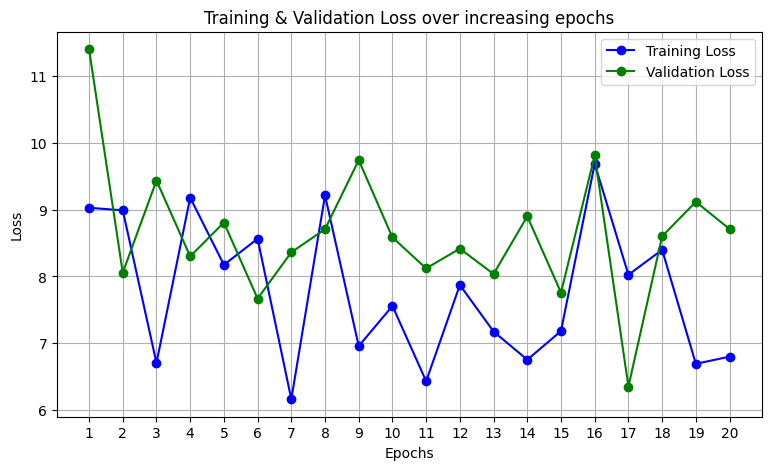

/tmp/ipykernel_71/3131386189.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


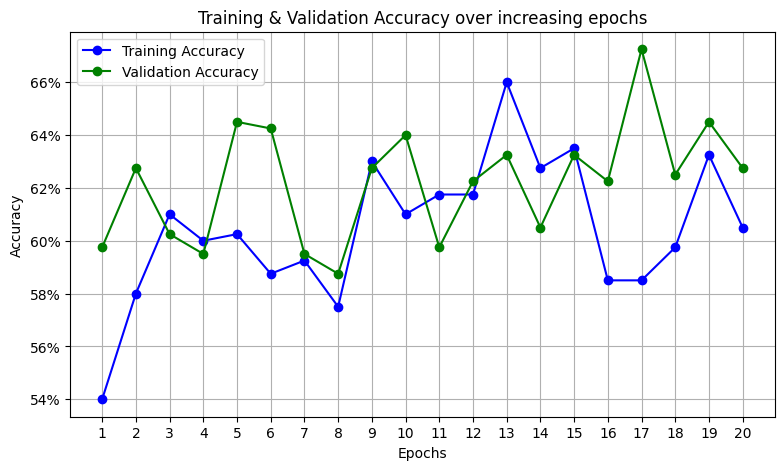

In [25]:
epochs = np.arange(max_epoch) + 1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Training & Validation Loss over increasing epochs')
plt.plot(epochs, train_loss_list,'bo-', label='Training Loss')
plt.plot(epochs, validation_loss_list,'go-', label='Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(122)
plt.title('Training & Validation Accuracy over increasing epochs')
plt.plot(epochs, train_accuracy_list, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_list, 'go-', label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show() 

In [26]:
d = []

# loop through loss and accuracy values
for epoch, (train_loss, validation_loss, train_acc, validation_acc) in enumerate(zip(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list)):
  
  d.append({"Epoch": epoch, "Training_Loss": train_loss, "Validation_loss": validation_loss, "Training_Acc": train_acc, "Validation_Acc": validation_acc})

In [27]:
temp_dataframe = pd.DataFrame(d)
temp_dataframe.head()

,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,9.028986,11.403512,0.5400,0.5975
1,1,8.990884,8.057390,0.5800,0.6275
2,2,6.704555,9.437047,0.6100,0.6025
3,3,9.181451,8.301372,0.6000,0.5950
4,4,8.174307,8.808024,0.6025,0.6450


In [28]:
img_height, img_width = 224, 224
data_dir = test_data_dir
x_test, y_test = read_xray_images(data_dir, img_height, img_width, augmentation=False)

In [29]:
x_test.shape, y_test.shape

((90, 224, 224, 3), (90,))

## Testing Prototypical Network using the model (2 way 3 shot DenseNet121)

In [30]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 19.036, Accuracy: 0.55
Episode: 100 ---> Loss: 17.003, Accuracy: 0.45
Episode: 200 ---> Loss: 11.929, Accuracy: 0.75
Episode: 300 ---> Loss: 5.761, Accuracy: 0.80
Episode: 400 ---> Loss: 0.976, Accuracy: 0.95
Episode: 500 ---> Loss: 12.456, Accuracy: 0.40
Episode: 600 ---> Loss: 17.162, Accuracy: 0.35
Episode: 700 ---> Loss: 2.122, Accuracy: 0.85
Episode: 800 ---> Loss: 4.074, Accuracy: 0.75
Episode: 900 ---> Loss: 6.446, Accuracy: 0.70
Episode: 1000 ---> Loss: 12.710, Accuracy: 0.55
Episode: 1100 ---> Loss: 4.992, Accuracy: 0.75
Episode: 1200 ---> Loss: 2.496, Accuracy: 0.70
Episode: 1300 ---> Loss: 3.132, Accuracy: 0.80
Episode: 1400 ---> Loss: 3.581, Accuracy: 0.70
Episode: 1500 ---> Loss: 10.666, Accuracy: 0.60
Episode: 1600 ---> Loss: 3.931, Accuracy: 0.80
Episode: 1700 ---> Loss: 4.659, Accuracy: 0.90
Episode: 1800 ---> Loss: 12.274, Accuracy: 0.65
Episode: 1900 ---> Loss: 1.467, Accuracy: 0.90
Episode: 2000 ---> L

## Testing a Prototypical Network using the model (2 way 5 shot DenseNet121)

In [31]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 5.156, Accuracy: 0.70
Episode: 100 ---> Loss: 1.538, Accuracy: 0.90
Episode: 200 ---> Loss: 1.858, Accuracy: 0.90
Episode: 300 ---> Loss: 3.078, Accuracy: 0.80
Episode: 400 ---> Loss: 10.233, Accuracy: 0.60
Episode: 500 ---> Loss: 2.879, Accuracy: 0.70
Episode: 600 ---> Loss: 6.443, Accuracy: 0.70
Episode: 700 ---> Loss: 9.555, Accuracy: 0.50
Episode: 800 ---> Loss: 3.681, Accuracy: 0.70
Episode: 900 ---> Loss: 0.343, Accuracy: 0.95
Episode: 1000 ---> Loss: 3.910, Accuracy: 0.80
Episode: 1100 ---> Loss: 2.503, Accuracy: 0.85
Episode: 1200 ---> Loss: 2.699, Accuracy: 0.80
Episode: 1300 ---> Loss: 0.699, Accuracy: 0.95
Episode: 1400 ---> Loss: 3.116, Accuracy: 0.80
Episode: 1500 ---> Loss: 1.387, Accuracy: 0.90
Episode: 1600 ---> Loss: 0.204, Accuracy: 0.95
Episode: 1700 ---> Loss: 9.648, Accuracy: 0.60
Episode: 1800 ---> Loss: 6.946, Accuracy: 0.45
Episode: 1900 ---> Loss: 6.957, Accuracy: 0.60
Episode: 2000 ---> Loss: 2.

## Test a Prototypical Network using the model (3 way 3 shot DenseNet121)

In [32]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 3
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 23.191, Accuracy: 0.37
Episode: 100 ---> Loss: 13.241, Accuracy: 0.57
Episode: 200 ---> Loss: 15.162, Accuracy: 0.33
Episode: 300 ---> Loss: 12.798, Accuracy: 0.60
Episode: 400 ---> Loss: 10.563, Accuracy: 0.67
Episode: 500 ---> Loss: 6.987, Accuracy: 0.73
Episode: 600 ---> Loss: 13.034, Accuracy: 0.30
Episode: 700 ---> Loss: 16.389, Accuracy: 0.50
Episode: 800 ---> Loss: 13.339, Accuracy: 0.43
Episode: 900 ---> Loss: 17.837, Accuracy: 0.30
Episode: 1000 ---> Loss: 11.769, Accuracy: 0.53
Episode: 1100 ---> Loss: 6.401, Accuracy: 0.60
Episode: 1200 ---> Loss: 10.511, Accuracy: 0.50
Episode: 1300 ---> Loss: 10.470, Accuracy: 0.67
Episode: 1400 ---> Loss: 10.439, Accuracy: 0.57
Episode: 1500 ---> Loss: 12.472, Accuracy: 0.50
Episode: 1600 ---> Loss: 12.210, Accuracy: 0.53
Episode: 1700 ---> Loss: 8.210, Accuracy: 0.70
Episode: 1800 ---> Loss: 6.965, Accuracy: 0.53
Episode: 1900 ---> Loss: 13.657, Accuracy: 0.57
Episode: 200

## Test a Prototypical Network using the model (3 way 5 shot DenseNet121)

In [33]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 6.735, Accuracy: 0.60
Episode: 100 ---> Loss: 11.507, Accuracy: 0.60
Episode: 200 ---> Loss: 10.417, Accuracy: 0.63
Episode: 300 ---> Loss: 10.347, Accuracy: 0.60
Episode: 400 ---> Loss: 7.929, Accuracy: 0.57
Episode: 500 ---> Loss: 6.048, Accuracy: 0.73
Episode: 600 ---> Loss: 4.473, Accuracy: 0.77
Episode: 700 ---> Loss: 5.658, Accuracy: 0.60
Episode: 800 ---> Loss: 8.836, Accuracy: 0.53
Episode: 900 ---> Loss: 4.818, Accuracy: 0.67
Episode: 1000 ---> Loss: 7.715, Accuracy: 0.63
Episode: 1100 ---> Loss: 10.579, Accuracy: 0.57
Episode: 1200 ---> Loss: 6.489, Accuracy: 0.57
Episode: 1300 ---> Loss: 12.758, Accuracy: 0.43
Episode: 1400 ---> Loss: 4.781, Accuracy: 0.60
Episode: 1500 ---> Loss: 6.886, Accuracy: 0.67
Episode: 1600 ---> Loss: 6.427, Accuracy: 0.63
Episode: 1700 ---> Loss: 9.398, Accuracy: 0.57
Episode: 1800 ---> Loss: 11.670, Accuracy: 0.60
Episode: 1900 ---> Loss: 4.037, Accuracy: 0.70
Episode: 2000 ---> Los

## Train a Prototypical Network using the model (2 way 3 shot ResNet50)

In [34]:
model = prototypical_network.ProtoNet(resnet50_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 3   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

# name to save model as
filename = "ResNet-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)

# Print out the average accuracies and losses (as percentage)
print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 7.801 | Train Acc: 59.50%
	 Val. Loss: 11.309 | Val. Acc: 60.50%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 2.076 | Train Acc: 82.50%
	 Val. Loss: 10.126 | Val. Acc: 57.50%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 0.808 | Train Acc: 91.50%
	 Val. Loss: 9.091 | Val. Acc: 57.75%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 0.539 | Train Acc: 94.75%
	 Val. Loss: 9.014 | Val. Acc: 57.75%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 0.977 | Train Acc: 92.50%
	 Val. Loss: 9.385 | Val. Acc: 56.75%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 0.544 | Train Acc: 95.00%
	 Val. Loss: 8.879 | Val. Acc: 57.25%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 0.644 | Train Acc: 94.50%
	 Val. Loss: 8.844 | Val. Acc: 57.75%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 0.359 | Train Acc: 95.00%
	 Val. Loss: 10.168 | Val. Acc: 59.75%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 0.492 | Train Acc: 95.75%
	 Val. Loss: 10.283 | Val. Acc: 56.25%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 0.787 | Train Acc: 93.50%
	 Val. Loss: 10.721 | Val. Acc: 56.00%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 0.662 | Train Acc: 95.50%
	 Val. Loss: 11.552 | Val. Acc: 52.50%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 0.744 | Train Acc: 93.00%
	 Val. Loss: 9.947 | Val. Acc: 54.25%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 0.566 | Train Acc: 92.75%
	 Val. Loss: 10.352 | Val. Acc: 57.75%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 0.503 | Train Acc: 94.00%
	 Val. Loss: 11.593 | Val. Acc: 59.25%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 0.225 | Train Acc: 96.25%
	 Val. Loss: 10.398 | Val. Acc: 54.75%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 0.443 | Train Acc: 95.75%
	 Val. Loss: 10.385 | Val. Acc: 57.50%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 0.375 | Train Acc: 96.25%
	 Val. Loss: 9.784 | Val. Acc: 58.75%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 0.218 | Train Acc: 96.00%
	 Val. Loss: 10.377 | Val. Acc: 55.75%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 0.211 | Train Acc: 96.25%
	 Val. Loss: 8.563 | Val. Acc: 61.50%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 0.546 | Train Acc: 95.00%
	 Val. Loss: 12.035 | Val. Acc: 52.25%
Average Training Accuracy: 0.92%
Average Validation Accuracy: 0.57%


## Train a Prototypical Network using the model (2 way 5 shot ResNet50)

In [35]:
model = prototypical_network.ProtoNet(resnet50_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 5   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

# name to save model as
filename = "ResNet-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)

# Print out the average accuracies and losses (as percentage)
print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 0.008 | Train Acc: 99.75%
	 Val. Loss: 7.549 | Val. Acc: 55.00%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 0.023 | Train Acc: 99.75%
	 Val. Loss: 7.206 | Val. Acc: 55.00%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 0.040 | Train Acc: 99.50%
	 Val. Loss: 7.719 | Val. Acc: 57.00%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 0.020 | Train Acc: 99.25%
	 Val. Loss: 8.859 | Val. Acc: 54.25%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 6.918 | Val. Acc: 60.50%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.332 | Val. Acc: 57.75%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.073 | Val. Acc: 60.00%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 8.153 | Val. Acc: 58.50%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.777 | Val. Acc: 56.25%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.419 | Val. Acc: 58.75%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 8.819 | Val. Acc: 53.50%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 0.018 | Train Acc: 99.75%
	 Val. Loss: 7.899 | Val. Acc: 59.25%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 7.885 | Val. Acc: 59.25%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 0.004 | Train Acc: 99.75%
	 Val. Loss: 8.395 | Val. Acc: 56.50%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.241 | Val. Acc: 56.75%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 0.003 | Train Acc: 99.75%
	 Val. Loss: 7.181 | Val. Acc: 59.75%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.027 | Val. Acc: 59.75%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 0.003 | Train Acc: 99.75%
	 Val. Loss: 7.879 | Val. Acc: 55.75%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.231 | Val. Acc: 55.75%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 7.042 | Val. Acc: 59.50%
Average Training Accuracy: 1.00%
Average Validation Accuracy: 0.57%


## Test a Prototypical Network using the model (2 way 3 shot ResNet50)

In [36]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 0.239, Accuracy: 0.95
Episode: 100 ---> Loss: 1.027, Accuracy: 0.90
Episode: 200 ---> Loss: 4.078, Accuracy: 0.70
Episode: 300 ---> Loss: 2.155, Accuracy: 0.85
Episode: 400 ---> Loss: 0.739, Accuracy: 0.95
Episode: 500 ---> Loss: 2.776, Accuracy: 0.80
Episode: 600 ---> Loss: 13.206, Accuracy: 0.50
Episode: 700 ---> Loss: 2.498, Accuracy: 0.70
Episode: 800 ---> Loss: 2.993, Accuracy: 0.80
Episode: 900 ---> Loss: 17.637, Accuracy: 0.55
Episode: 1000 ---> Loss: 9.799, Accuracy: 0.65
Episode: 1100 ---> Loss: 18.807, Accuracy: 0.30
Episode: 1200 ---> Loss: 3.644, Accuracy: 0.90
Episode: 1300 ---> Loss: 10.474, Accuracy: 0.70
Episode: 1400 ---> Loss: 2.028, Accuracy: 0.80
Episode: 1500 ---> Loss: 0.863, Accuracy: 0.85
Episode: 1600 ---> Loss: 12.519, Accuracy: 0.55
Episode: 1700 ---> Loss: 5.767, Accuracy: 0.65
Episode: 1800 ---> Loss: 2.361, Accuracy: 0.85
Episode: 1900 ---> Loss: 17.226, Accuracy: 0.70
Episode: 2000 ---> Los

## Train a Prototypical Network using the model (2 way 5 shot ResNet50)

In [37]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 2.475, Accuracy: 0.70
Episode: 100 ---> Loss: 2.924, Accuracy: 0.80
Episode: 200 ---> Loss: 3.047, Accuracy: 0.75
Episode: 300 ---> Loss: 7.706, Accuracy: 0.55
Episode: 400 ---> Loss: 1.876, Accuracy: 0.85
Episode: 500 ---> Loss: 1.081, Accuracy: 0.90
Episode: 600 ---> Loss: 1.793, Accuracy: 0.95
Episode: 700 ---> Loss: 2.990, Accuracy: 0.75
Episode: 800 ---> Loss: 6.510, Accuracy: 0.75
Episode: 900 ---> Loss: 6.464, Accuracy: 0.70
Episode: 1000 ---> Loss: 14.756, Accuracy: 0.35
Episode: 1100 ---> Loss: 3.336, Accuracy: 0.75
Episode: 1200 ---> Loss: 5.262, Accuracy: 0.60
Episode: 1300 ---> Loss: 2.537, Accuracy: 0.85
Episode: 1400 ---> Loss: 2.452, Accuracy: 0.60
Episode: 1500 ---> Loss: 0.918, Accuracy: 0.90
Episode: 1600 ---> Loss: 1.363, Accuracy: 0.80
Episode: 1700 ---> Loss: 4.100, Accuracy: 0.70
Episode: 1800 ---> Loss: 0.407, Accuracy: 0.90
Episode: 1900 ---> Loss: 1.989, Accuracy: 0.80
Episode: 2000 ---> Loss: 3.

## Train a Prototypical Network using the model (3 way 3 shot ResNet50)

In [38]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 3
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 6.276, Accuracy: 0.57
Episode: 100 ---> Loss: 7.111, Accuracy: 0.67
Episode: 200 ---> Loss: 5.550, Accuracy: 0.67
Episode: 300 ---> Loss: 3.994, Accuracy: 0.80
Episode: 400 ---> Loss: 30.040, Accuracy: 0.40
Episode: 500 ---> Loss: 7.377, Accuracy: 0.60
Episode: 600 ---> Loss: 17.010, Accuracy: 0.60
Episode: 700 ---> Loss: 19.659, Accuracy: 0.50
Episode: 800 ---> Loss: 5.287, Accuracy: 0.73
Episode: 900 ---> Loss: 10.318, Accuracy: 0.47
Episode: 1000 ---> Loss: 7.183, Accuracy: 0.63
Episode: 1100 ---> Loss: 6.492, Accuracy: 0.70
Episode: 1200 ---> Loss: 8.762, Accuracy: 0.57
Episode: 1300 ---> Loss: 9.264, Accuracy: 0.67
Episode: 1400 ---> Loss: 4.707, Accuracy: 0.57
Episode: 1500 ---> Loss: 8.416, Accuracy: 0.60
Episode: 1600 ---> Loss: 4.337, Accuracy: 0.77
Episode: 1700 ---> Loss: 5.222, Accuracy: 0.80
Episode: 1800 ---> Loss: 16.813, Accuracy: 0.43
Episode: 1900 ---> Loss: 6.360, Accuracy: 0.67
Episode: 2000 ---> Loss

## Train a Prototypical Network using the model (3 way 5 shot ResNet50)

In [39]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 9.103, Accuracy: 0.63
Episode: 100 ---> Loss: 1.544, Accuracy: 0.83
Episode: 200 ---> Loss: 5.668, Accuracy: 0.53
Episode: 300 ---> Loss: 7.530, Accuracy: 0.43
Episode: 400 ---> Loss: 6.746, Accuracy: 0.53
Episode: 500 ---> Loss: 4.078, Accuracy: 0.70
Episode: 600 ---> Loss: 3.883, Accuracy: 0.73
Episode: 700 ---> Loss: 4.464, Accuracy: 0.67
Episode: 800 ---> Loss: 6.751, Accuracy: 0.70
Episode: 900 ---> Loss: 9.676, Accuracy: 0.60
Episode: 1000 ---> Loss: 6.221, Accuracy: 0.63
Episode: 1100 ---> Loss: 3.995, Accuracy: 0.70
Episode: 1200 ---> Loss: 14.444, Accuracy: 0.60
Episode: 1300 ---> Loss: 4.292, Accuracy: 0.63
Episode: 1400 ---> Loss: 6.334, Accuracy: 0.70
Episode: 1500 ---> Loss: 6.751, Accuracy: 0.60
Episode: 1600 ---> Loss: 7.076, Accuracy: 0.53
Episode: 1700 ---> Loss: 8.026, Accuracy: 0.50
Episode: 1800 ---> Loss: 5.295, Accuracy: 0.63
Episode: 1900 ---> Loss: 6.419, Accuracy: 0.53
Episode: 2000 ---> Loss: 14